# Plan & Execute
Inspiration: https://blog.langchain.dev/planning-agents/

Plan & Execute Agents consists of two basic components:

1. A **planner**, which prompts an (usually large and powerful) LLM to generate a multi-step plan to complete a large task.
2. An **executor**, (potentially many) which accept the user query and a step in the plan and invoke 1 or more tools to complete that task.

In [142]:
import os

os.environ["OPENAI_API_KEY"] = 'sk-***'

## Setting up a basic ReAct Agent as the Executor

In [151]:
from langchain_community.tools import DuckDuckGoSearchRun  # Initialize the tool
search_ddg_tool = DuckDuckGoSearchRun()

tools = [search_ddg_tool]

In [155]:
from langchain import hub
from langchain_openai import ChatOpenAI

from langgraph.prebuilt import create_react_agent

# Get the prompt to use - you can modify this!
prompt = hub.pull("ih/ih-react-agent-executor")
prompt.pretty_print()

# Choose the LLM that will drive the agent
llm = ChatOpenAI(model="gpt-4o-mini")
agent_executor = create_react_agent(llm, tools, state_modifier=prompt)

/Users/sinanozdemir/Teaching/Pearson/oreilly-ai-agents/.venv/lib/python3.11/site-packages/langsmith/client.py:241: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


================================ System Message ================================

You are a helpful assistant.

============================= Messages Placeholder =============================

{messages}


In [158]:
response = agent_executor.invoke({"messages": [("user", "Who won the most recent Ravens game?")]})

In [159]:
response['messages'][-1].content  # correct as of 11/19/24

"The most recent game for the Baltimore Ravens was against the Pittsburgh Steelers, which they lost 18-16. The game took place on October 8, 2023. The Steelers' kicker, Chris Boswell, was the standout player, scoring all of their points with six field goals."

## The Planner

In [160]:
from pydantic import BaseModel, Field
from typing import List
from langchain_core.prompts import ChatPromptTemplate

class Plan(BaseModel):
    """Plan to follow in future"""

    steps: List[str] = Field(
        description="different steps to follow, should be in sorted order"
    )

planner_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """For the given objective, come up with a simple step by step plan. \
This plan should involve individual tasks, that if executed correctly will yield the correct answer. Do not add any superfluous steps. \
The result of the final step should be the final answer. Make sure that each step has all the information needed - do not skip steps.""",
        ),
        ("placeholder", "{messages}"),
    ]
)
planner = planner_prompt | ChatOpenAI(
    model="gpt-4o-mini", temperature=0
).with_structured_output(Plan)


In [161]:
plan = planner.invoke(
    {
        "messages": [
            ("user", "what is the hometown of the QB of the winner of the most recent Ravens game?")
        ]
    }
)
plan

Plan(steps=['Identify the most recent game played by the Baltimore Ravens.', 'Determine the outcome of that game (win or loss).', 'If the Ravens won, identify the starting quarterback (QB) for that game.', 'Research the hometown of that quarterback.'])

In [169]:
from typing import Union


class Response(BaseModel):
    """Response to user."""

    response: str


class Act(BaseModel):
    """Action to perform."""

    action: Union[Response, Plan] = Field(
        description="Action to perform. If you want to respond to user, use Response. "
        "If you need to further use tools to get the answer, use Plan."
    )


replanner_prompt = ChatPromptTemplate.from_template(
    """For the given objective, come up with a simple step by step plan. \
This plan should involve individual tasks, that if executed correctly will yield the correct answer. Do not add any superfluous steps. \
The result of the final step should be the final answer. Make sure that each step has all the information needed - do not skip steps.

Your objective was this:
{input}

Your original plan was this:
{plan}

You have currently done the following steps:
{past_steps}

Update your plan accordingly. If no more steps are needed and you can return to the user, then respond with that. Otherwise, fill out the plan. Only add steps to the plan that still NEED to be done. Do not return previously done steps as part of the plan."""
)


replanner = replanner_prompt | ChatOpenAI(
    model="gpt-4o", temperature=0
).with_structured_output(Act)

In [170]:
act = replanner.invoke(
    {
        "input": "what is the hometown of the QB of the winner of the most recent Ravens game?",
        "plan": plan,
        "past_steps": [('Identify the most recent game played by the Baltimore Ravens.', "They played the Steelers")],
        
    }
)

In [ ]:
# New steps
new_plan = act.action


In [179]:
type(new_plan)

__main__.Plan

In [171]:
new_plan.steps

['Determine the outcome of the game between the Baltimore Ravens and the Pittsburgh Steelers (win or loss).',
 'If the Ravens won, identify the starting quarterback (QB) for that game.',
 'Research the hometown of that quarterback.']

## Building the Graph

In [55]:
import operator
from typing import Annotated, List, Tuple
from typing_extensions import TypedDict

class PlanExecute(TypedDict):  # our graph state (short term memory in between the steps)
    input: str
    plan: List[str]
    past_steps: Annotated[List[Tuple], operator.add]
    response: str

In [206]:
from typing import Literal
from langgraph.graph import END


def execute_step(state: PlanExecute):
    plan = state["plan"]
    plan_str = "\n".join(f"{i+1}. {step}" for i, step in enumerate(plan))
    task = plan[0]
    task_formatted = f"""For the following plan:
{plan_str}\n\nYou are tasked with executing step {1}, {task}."""
    print('-----------------------')
    print('Formatted Task at Execute', task_formatted)
    print('-----------------------')
    agent_response = agent_executor.invoke(
        {"messages": [("user", task_formatted)]}
    )
    return {
        "past_steps": [(task, agent_response["messages"][-1].content)],
    }

def plan_step(state: PlanExecute):
    plan = planner.invoke({"messages": [("user", state["input"])]})
    return {"plan": plan.steps}


def replan_step(state: PlanExecute):
    output = replanner.invoke(state)
    if isinstance(output.action, Response):
        print('A response was given!')
        return {"response": output.action.response}
    else:
        return {"plan": output.action.steps}


def should_end(state: PlanExecute):
    if "response" in state and state["response"]:
        return END
    else:
        return "executor"

In [207]:
from langgraph.graph import StateGraph, START

workflow = StateGraph(PlanExecute)

# Add the plan node
workflow.add_node("planner", plan_step)

# Add the execution step
workflow.add_node("executor", execute_step)

# Add a replan node
workflow.add_node("replan", replan_step)

workflow.add_edge(START, "planner")

# From plan we go to agent
workflow.add_edge("planner", "executor")

# From agent, we replan
workflow.add_edge("executor", "replan")

workflow.add_conditional_edges(
    "replan",
    # Next, we pass in the function that will determine which node is called next.
    should_end,
    ["executor", END],
)

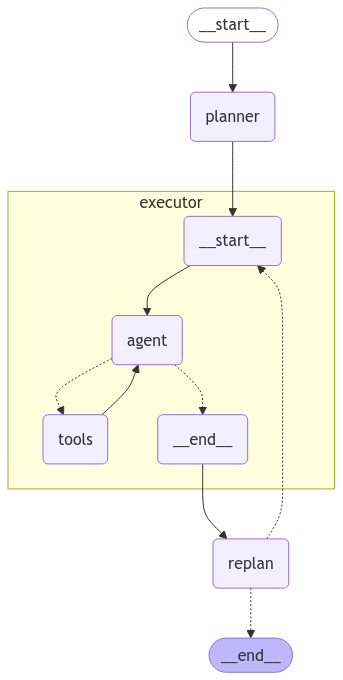

In [200]:
# Compile the graph
app = workflow.compile()
from IPython.display import Image, display

display(Image(app.get_graph(xray=True).draw_mermaid_png()))

## Using our Plan & Execute Agent

In [210]:
inputs = {"input": "what is the hometown of the QB of the winner of the Ravens game on 11/17/2024"}

for event in app.stream(inputs):
    for node_name, output in event.items():
        print(f'Node: {node_name}. Output: {output}')

Node: planner. Output: {'plan': ['Identify the date of the Ravens game on 11/17/2024.', 'Determine the opponent of the Ravens in that game.', 'Find out the winner of the Ravens game on that date.', 'Identify the starting quarterback (QB) of the winning team.', 'Research the hometown of that quarterback.']}
-----------------------
Formatted Task at Execute You are tasked with executing step 1, Identify the date of the Ravens game on 11/17/2024..
-----------------------
Node: executor. Output: {'past_steps': [('Identify the date of the Ravens game on 11/17/2024.', 'The Baltimore Ravens will play against the Pittsburgh Steelers on November 17, 2024. The game is scheduled to start at 1:00 PM and will take place at Acrisure Stadium in Pittsburgh, PA.')]}
Node: replan. Output: {'plan': ['Find out the winner of the Ravens game on 11/17/2024 against the Pittsburgh Steelers.', 'Identify the starting quarterback (QB) of the winning team.', 'Research the hometown of that quarterback.']}
---------

In [ ]:
for event in app.stream(inputs, stream_mode=['values']):  # Listen for state updates
    print(len(event[1].get('past_steps')), event[1].get('past_steps'))

0 []
0 []
-----------------------
Formatted Task at Execute You are tasked with executing step 1, Identify the date of the Ravens game on 11/17/2024..
-----------------------


In [ ]:
final_state = event[1]
final_state